In [1]:
import requests
import time
import datetime
import pandas as pd
from config import email, key
import matplotlib.pyplot as plt
import json

In [2]:
events = ["ci37908735","nc72737985","ci37374687","nc72282711","ci15200401","ci15199681","ci10736069",
          "ci14408052","ci14383980","nc40216664","nc40204628"]

i=0

earthquakes_list = []

for event in events:
    base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson"
    times_url = "&starttime=1990-01-01&endtime=2019-06-15"
    magnitude_url ="&minmagnitude=5.0"
    #geometry_url = "&minlatitude=32.43&maxlatitude=42.05&minlongitude=-124.28&maxlongitude=-114.11"
    eventid_url = f"&eventid={event}"
    
    search = requests.get(base_url + times_url + magnitude_url + eventid_url)
    
    response = search.json()

    identifier = response['id']
    mag = response['properties']['mag']
    url = response['properties']['url']
    epochtime = response['properties']['time']
    four_weeks_before = epochtime - 2419200000
    four_weeks_after = epochtime + 2419200000
    event_date= time.strftime('%Y%m%d',  time.gmtime(epochtime/1000))
    month_before= time.strftime('%Y%m%d',  time.gmtime(four_weeks_before/1000))
    month_after = time.strftime('%Y%m%d',  time.gmtime(four_weeks_after/1000))
    converted_time = time.strftime('%H:%M:%S',  time.gmtime(epochtime/1000))
    timezone=response['properties']['tz']
    place = response['properties']['place']
    significance=response['properties']['sig']
    lon = response['geometry']['coordinates'][0]
    lat = response['geometry']['coordinates'][1]
    depth = response['geometry']['coordinates'][2]
    record_dict = {"Identifier":identifier, "Location":place, "Magnitude":mag, "Event Date":event_date,
                   "Month Before":month_before, "Month After":month_after, "Time":converted_time,"Time Zone":timezone, 
                   "Significance":significance, "Lat":lat, "Lon":lon, "Depth":depth, "Epoch Time":epochtime}
    earthquakes_list.append(record_dict)
        
    i += 1
          
earthquakes_df = pd.DataFrame(earthquakes_list)

earthquakes_df = earthquakes_df[~earthquakes_df["Location"].str.contains("Mexico")]

earthquakes_df = earthquakes_df[~earthquakes_df["Location"].str.contains("MX")]

earthquakes_df = earthquakes_df[~earthquakes_df["Location"].str.contains("Nevada")]

earthquakes_df = earthquakes_df[~earthquakes_df["Location"].str.contains("NV")].reset_index()

earthquakes_df = earthquakes_df.fillna(value="")

earthquakes_abbrev =earthquakes_df[['Location', 'Event Date', 'Magnitude']]

pd.set_option('display.max_rows', None)

earthquakes_df.to_csv("DataFiles/earthquake_list.csv")

earthquakes_df 

,index,Identifier,Location,Magnitude,Event Date,Month Before,Month After,Time,Time Zone,Significance,Lat,Lon,Depth,Epoch Time
0,0,ci37908735,"29km SW of Santa Cruz Is. (E end), CA",5.29,20180405,20180308,20180503,19:29:16,-480,1011,33.837500,-119.725833,9.870,1522956556500
1,1,nc72737985,"8km NW of The Geysers, California",5.01,20161214,20161116,20170111,16:41:05,-480,589,38.822167,-122.841333,1.480,1481733665530
2,2,ci37374687,"20km NNW of Borrego Springs, CA",5.19,20160610,20160513,20160708,08:04:38,-420,1014,33.431500,-116.442667,12.310,1465545878700
3,3,nc72282711,South Napa,6.02,20140824,20140727,20140921,10:20:44,-420,2750,38.215167,-122.312333,11.120,1408875644070
4,4,ci15200401,"4km NNW of Brawley, CA",5.41,20120826,20120729,20120923,20:57:58,-480,1090,33.018500,-115.540333,8.283,1346014678220
5,5,ci15199681,"5km NNW of Brawley, CA",5.32,20120826,20120729,20120923,19:31:23,,1370,33.017167,-115.553667,8.323,1346009483040
6,6,ci10736069,"20km NNW of Borrego Springs, CA",5.42,20100707,20100609,20100804,23:53:33,-480,1032,33.417333,-116.474667,12.318,1278546813480
7,7,ci14408052,"26km WNW of Ludlow, CA",5.06,20081206,20081108,20090103,04:18:42,,824,34.813333,-116.418833,6.370,1228537122850
8,8,ci14383980,"5km S of Chino Hills, CA",5.44,20080729,20080701,20080826,18:42:15,,1095,33.948500,-117.766333,15.503,1217356935670
9,9,nc40216664,Northern California,5.40,20080430,20080402,20080528,03:03:06,,969,40.835833,-123.496833,27.755,1209524586900


In [3]:
earthquake = 0
record_list = []

for rows in earthquakes_df.iterrows():

    # base_url finds air quality readings by Box with daily summaries 

    base_url = "https://aqs.epa.gov/data/api/dailyData/byBox?"

    #parameters for byBox for CRITERIA Pollutants 
    #42401 = "Sulfur Dioxide" 
    #42602 = "Nitrogen Dioxide"
    #44201 = "Ozone"
    #42101 = "Carbon Monoxide"
    #81102 = "PM10 Total 0-10 um STP"
    #88101 = "PM2.5 - Local Conditions"

    begin = earthquakes_df.iloc[earthquake, 5]
    end = earthquakes_df.iloc[earthquake, 6]
    minlat=earthquakes_df.iloc[earthquake,10]-1
    maxlat=earthquakes_df.iloc[earthquake,10]+1
    minlon=earthquakes_df.iloc[earthquake,11]-1
    maxlon=earthquakes_df.iloc[earthquake,11]+1
    earthquake_location=earthquakes_df.iloc[earthquake,2]
    event_date =earthquakes_df.iloc[earthquake, 4]
    identifier = earthquakes_df,iloc[earthquake,1]
    
    param_url = f"param=42401,42602,44201,42101,81102,88101"
    date_range_url = f"&bdate={begin}&edate={end}"
    geometry_url = f"&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}"

    url = (base_url + param_url + "&email=" + email + "&key=" + key + date_range_url + geometry_url)
    
    print(earthquake_location+" "+event_date)
    
    search = requests.get(url)
    responses = search.json()
    
    i = 0
    
    for record in responses['Data']:
        site = responses['Data'][i]['local_site_name']
        station = responses['Data'][i]['site_number']
        parameter = responses['Data'][i]['parameter']
        date = responses['Data'][i]['date_local']
        measurement = responses['Data'][i]['arithmetic_mean']
        measurement_unit = responses['Data'][i]['units_of_measure']
        event_type=responses['Data'][i]["event_type"]
        lon = responses['Data'][i]['longitude']
        lat = responses['Data'][i]['latitude']
        earthquake_id = earthquakes_df.iloc[earthquake, 1]
        record_dict = {"Earthquake ID":earthquake_id,"Parameter":parameter,"Date":date,"Station":station,"Site":site, 
                        "Lat":lat,"Lon":lon, "Measurement":measurement, "Unit":measurement_unit,"Event Type":event_type}
        record_list.append(record_dict)

        i += 1
    
    earthquake += 1

print('Seaches Completed')

29km SW of Santa Cruz Is. (E end), CA 20180405
8km NW of The Geysers, California 20161214
20km NNW of Borrego Springs, CA 20160610
South Napa 20140824
4km NNW of Brawley, CA 20120826
5km NNW of Brawley, CA 20120826
20km NNW of Borrego Springs, CA 20100707
26km WNW of Ludlow, CA 20081206
5km S of Chino Hills, CA 20080729
Northern California 20080430
San Francisco Bay area, California 20071031
Seaches Completed


In [4]:
record_df = pd.DataFrame(record_list)
pd.set_option('display.max_rows', 100)
record_df.head()

,Earthquake ID,Parameter,Date,Station,Site,Lat,Lon,Measurement,Unit,Event Type
0,ci37908735,PM10 Total 0-10um STP,2018-03-09,4003,VAFB South Base,34.5959,-120.631315,21.571429,Micrograms/cubic meter (25 C),None
1,ci37908735,PM10 Total 0-10um STP,2018-03-10,4003,VAFB South Base,34.5959,-120.631315,13.500000,Micrograms/cubic meter (25 C),None
2,ci37908735,PM10 Total 0-10um STP,2018-03-11,4003,VAFB South Base,34.5959,-120.631315,14.666667,Micrograms/cubic meter (25 C),None
3,ci37908735,PM10 Total 0-10um STP,2018-03-12,4003,VAFB South Base,34.5959,-120.631315,11.583333,Micrograms/cubic meter (25 C),None
4,ci37908735,PM10 Total 0-10um STP,2018-03-13,4003,VAFB South Base,34.5959,-120.631315,10.875000,Micrograms/cubic meter (25 C),None


In [5]:
#pollutant2 = record df['Parameter','Unit']

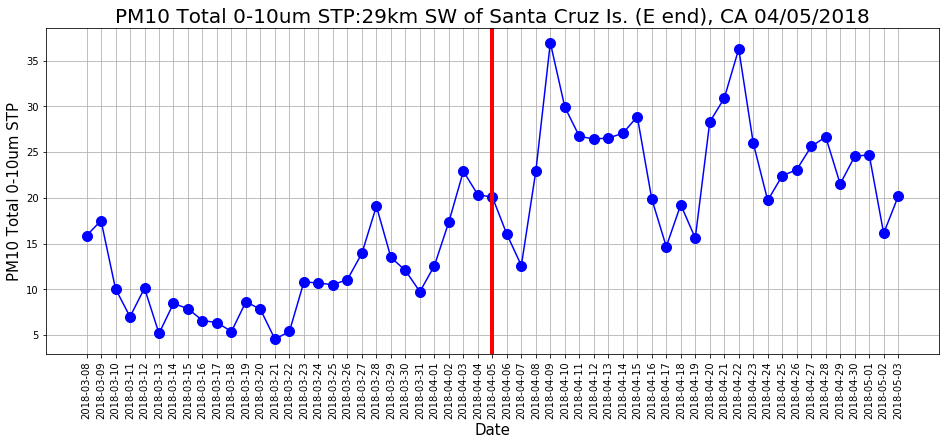

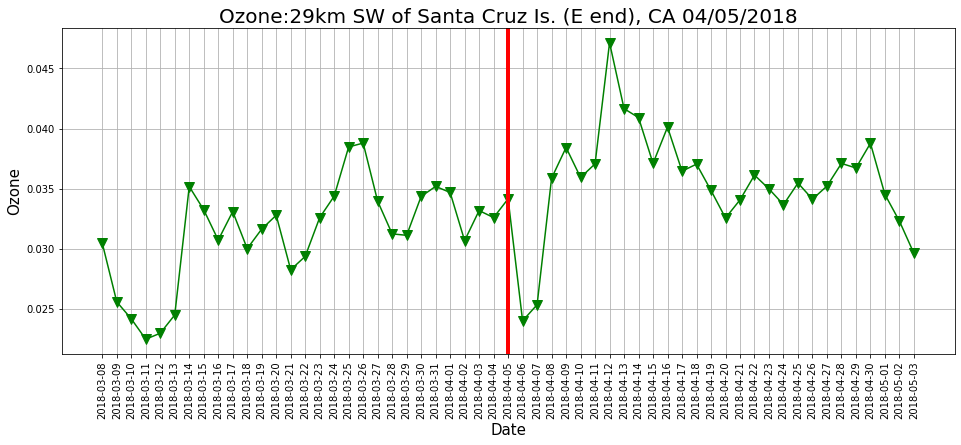

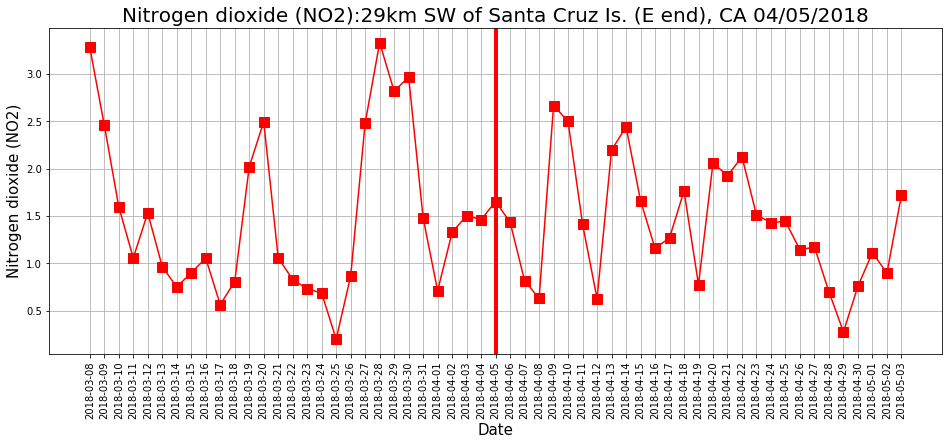

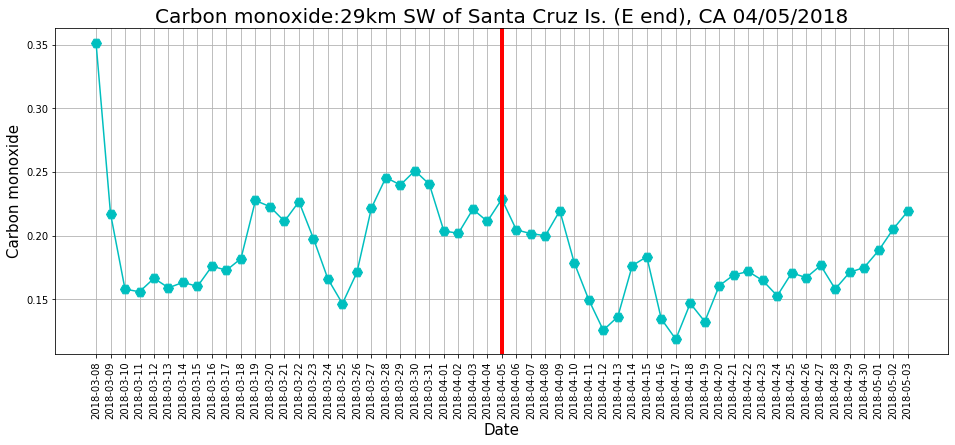

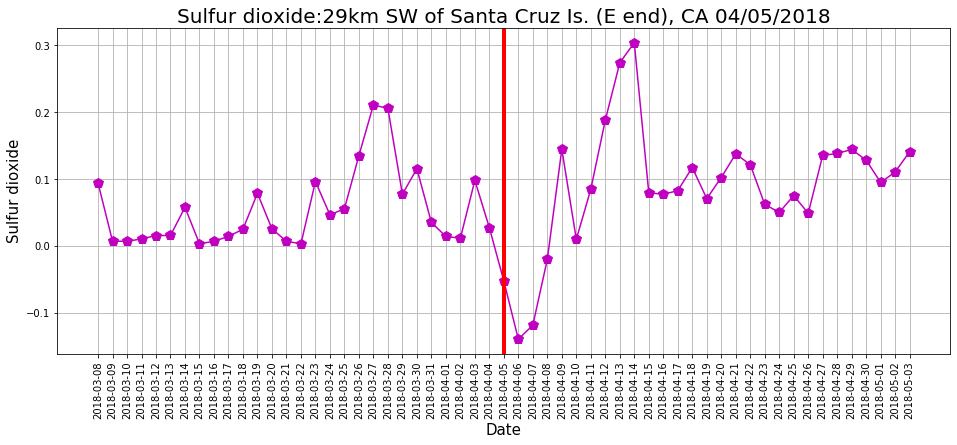

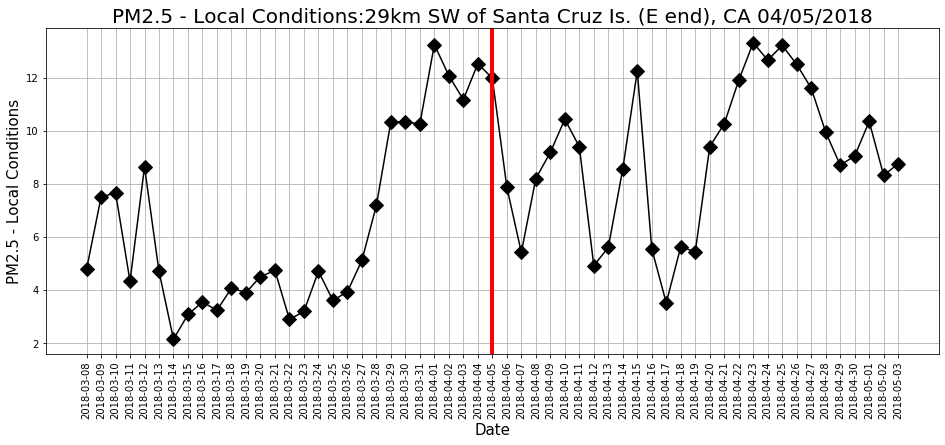

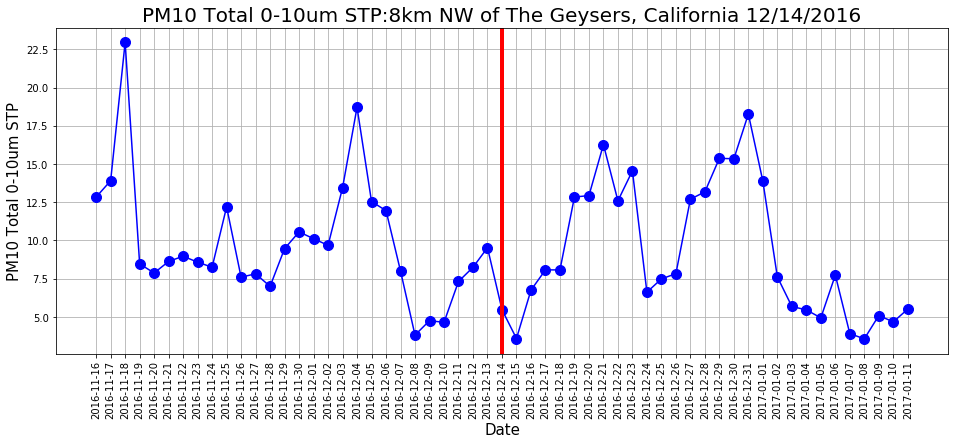

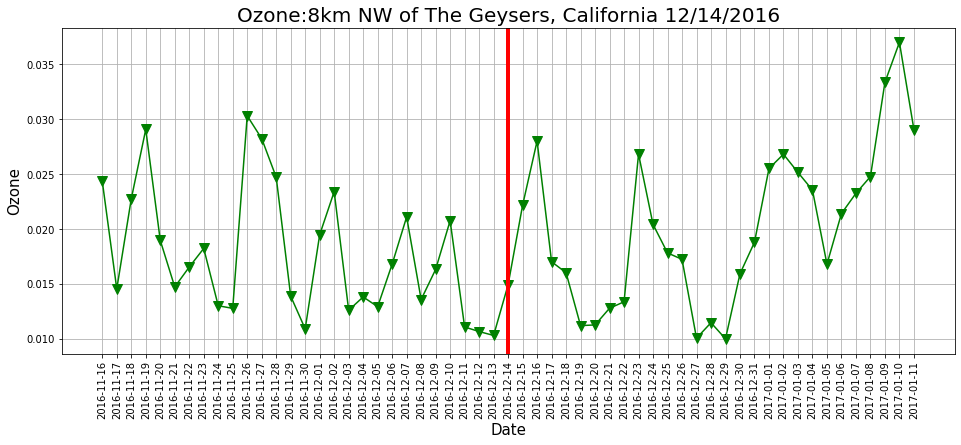

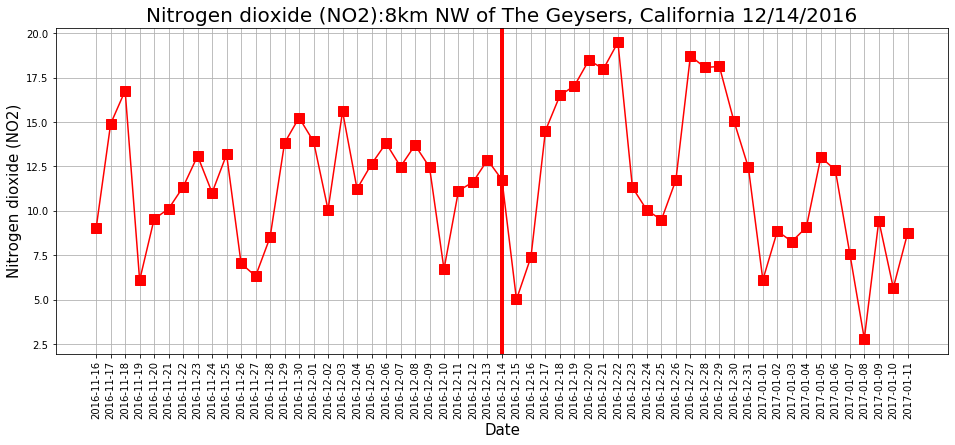

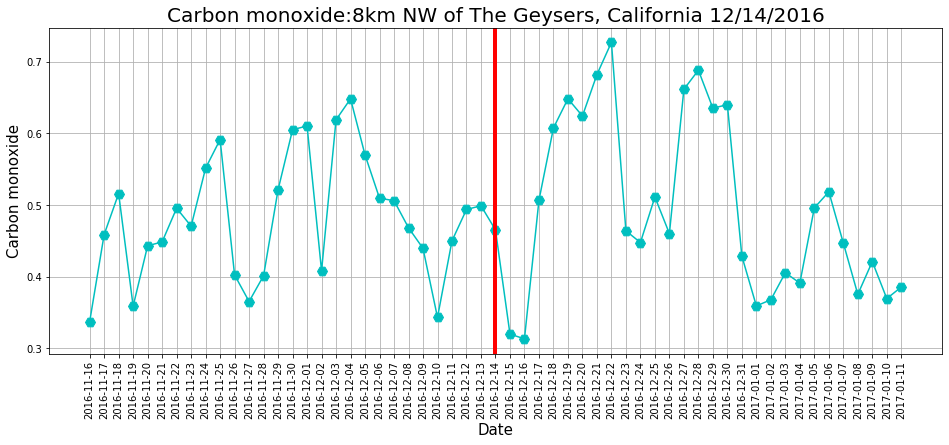

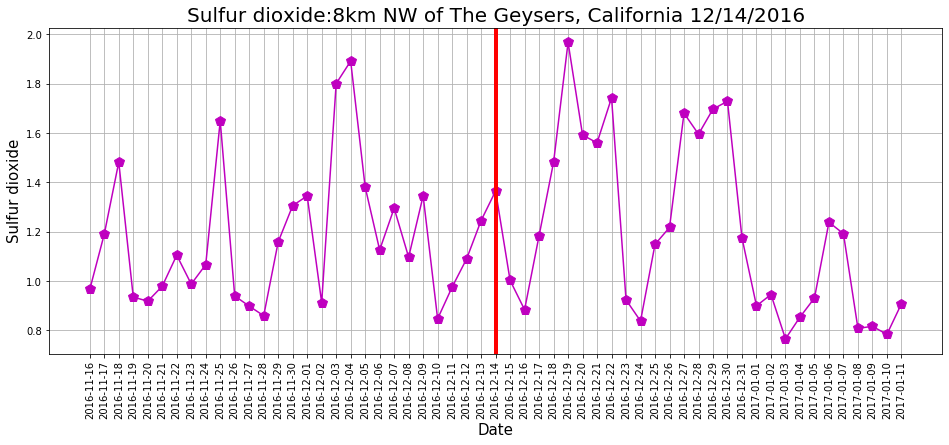

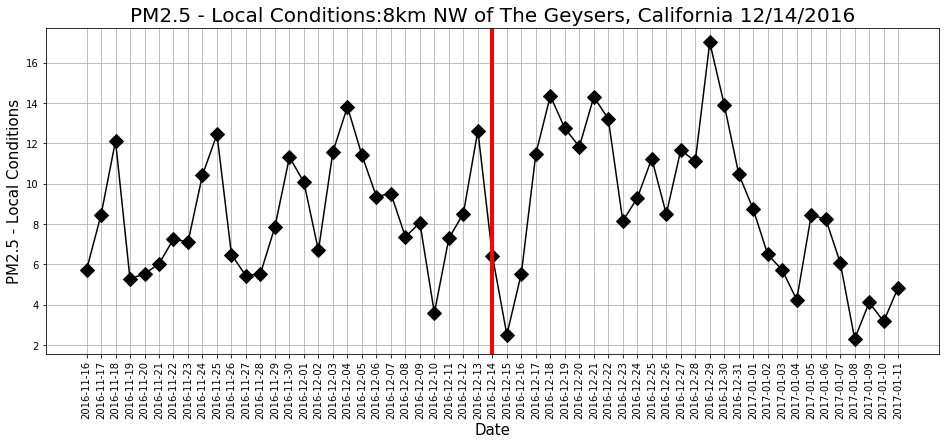

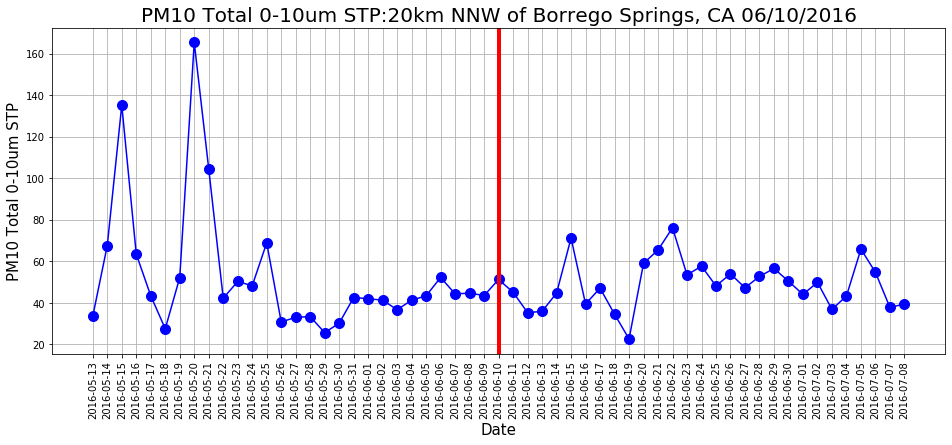

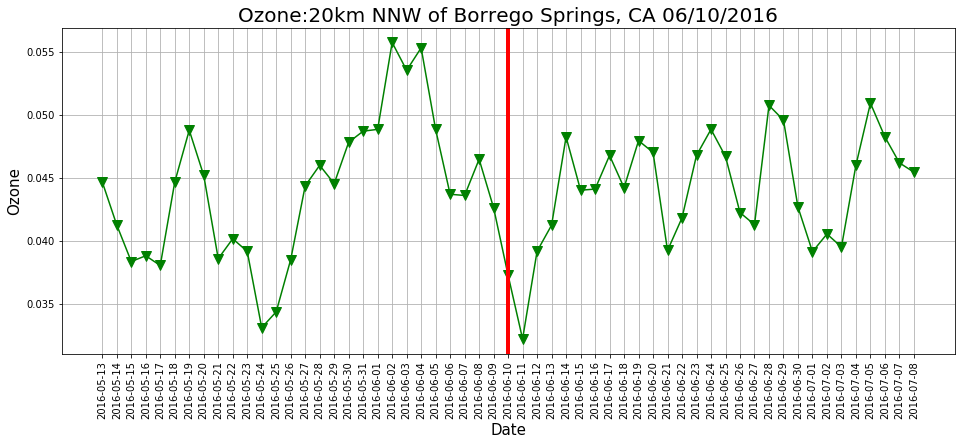

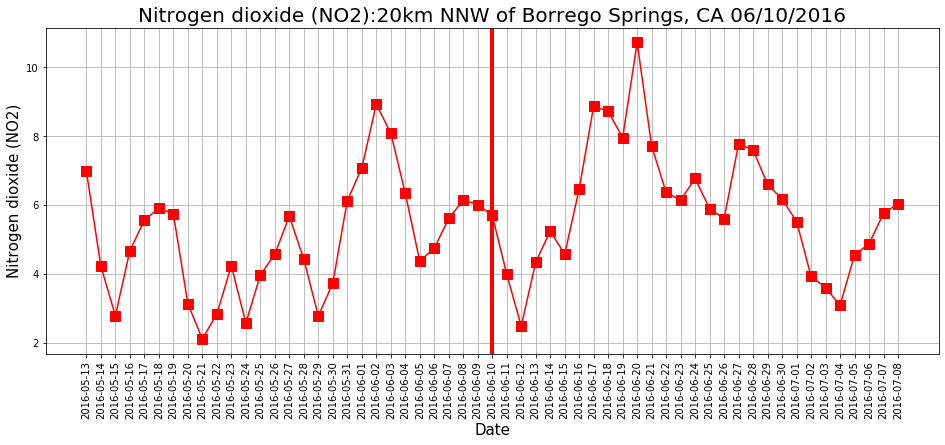

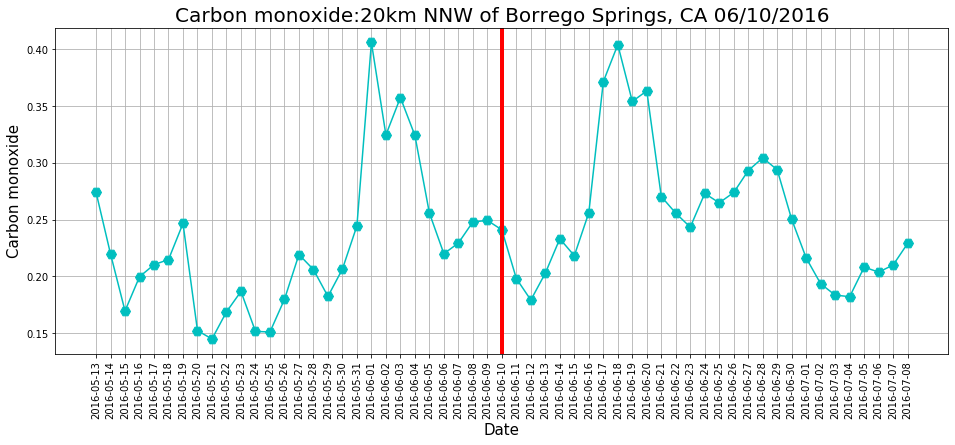

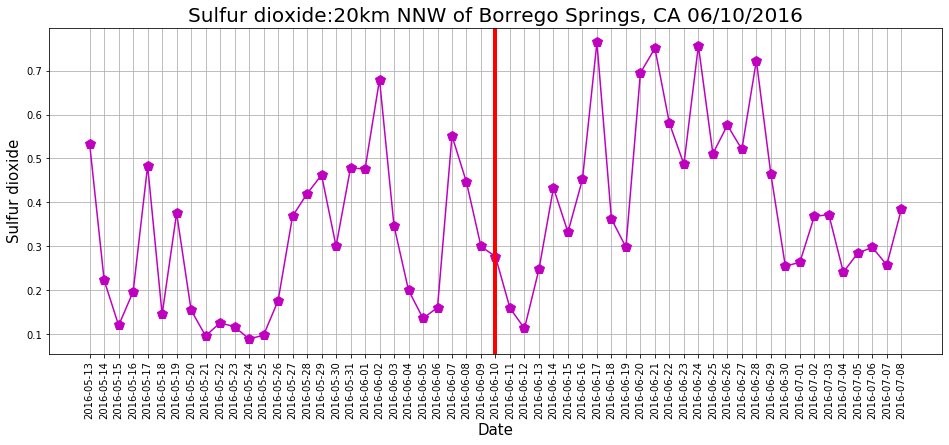

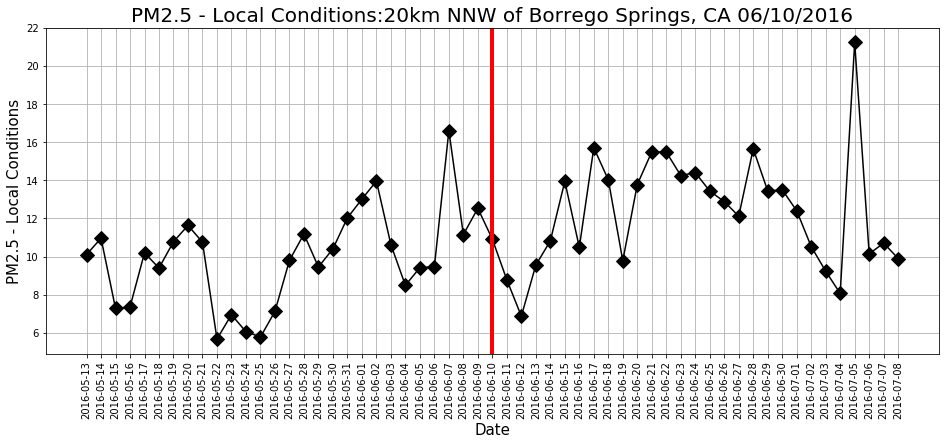

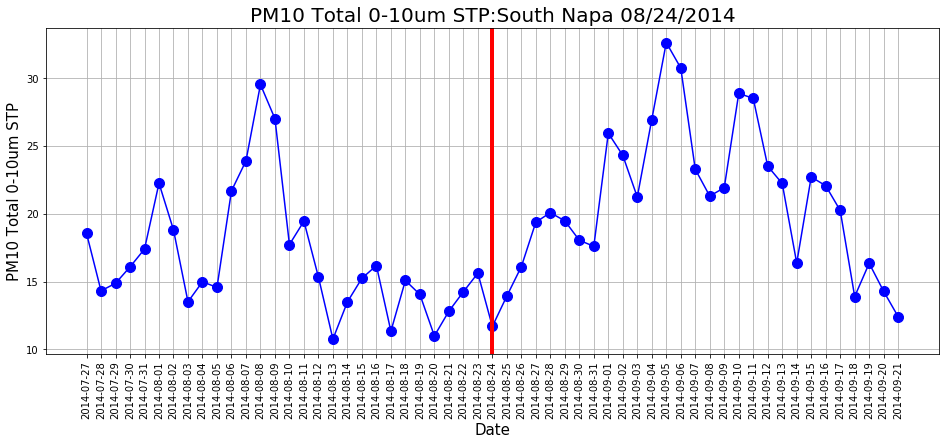

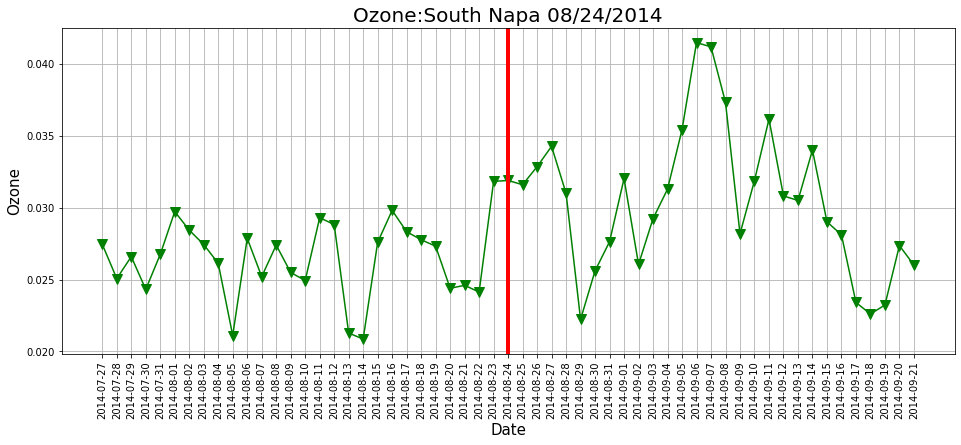

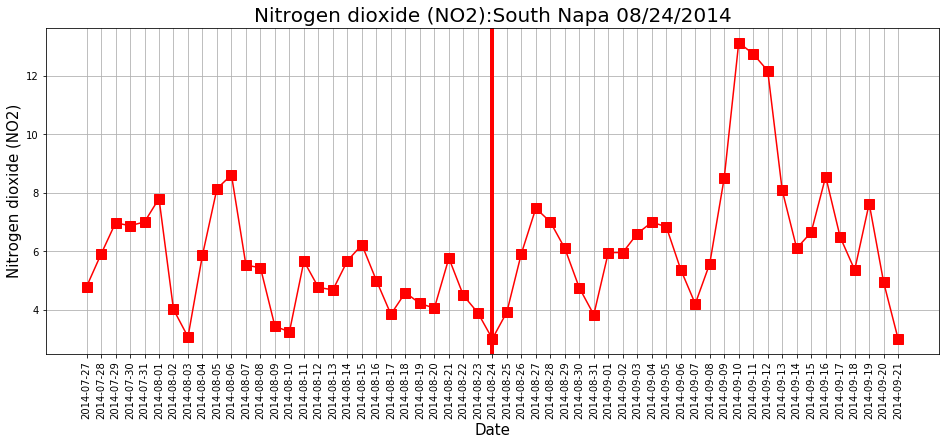

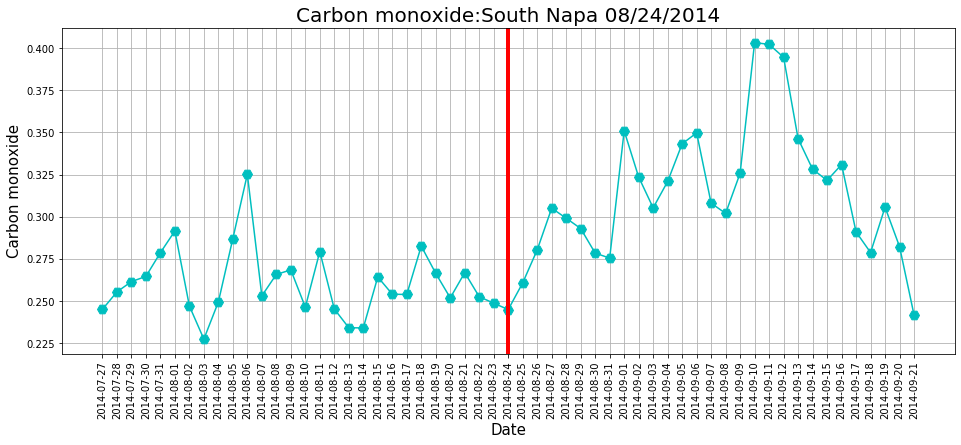

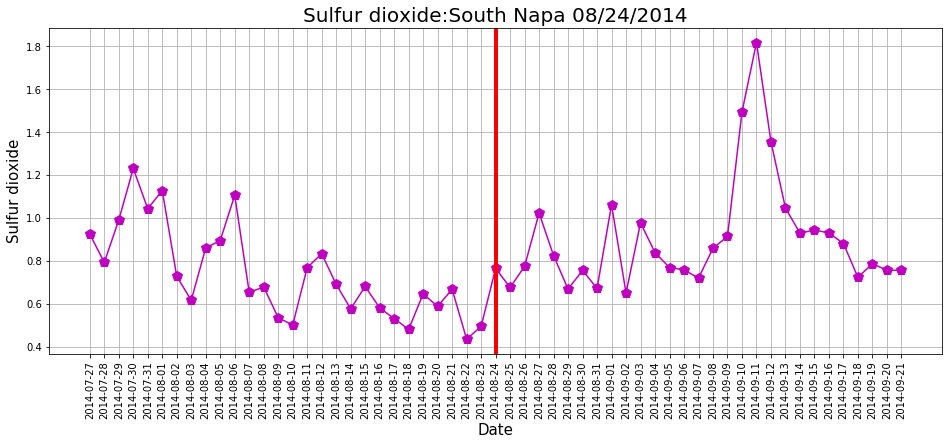

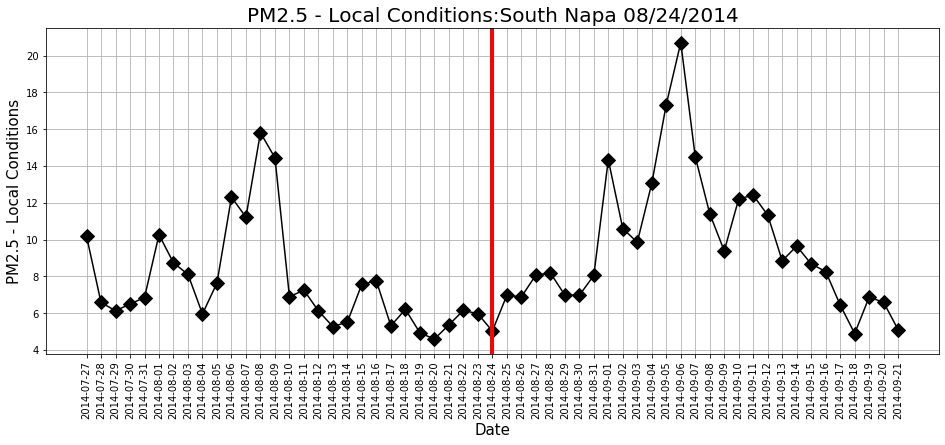

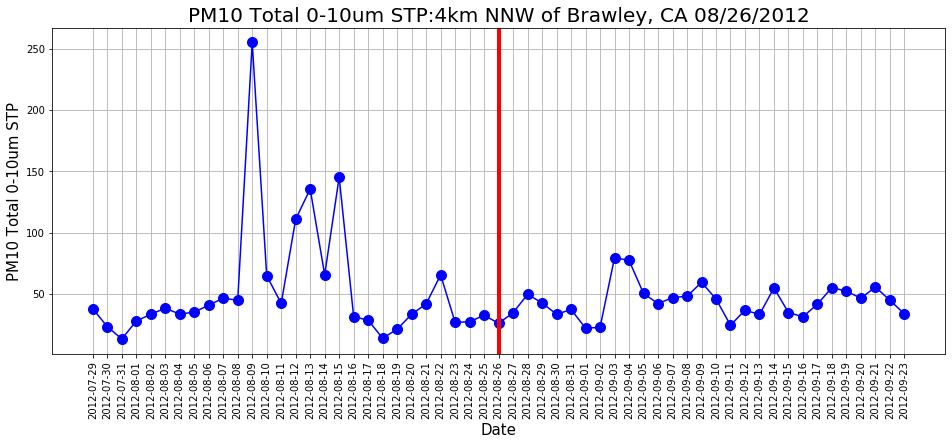

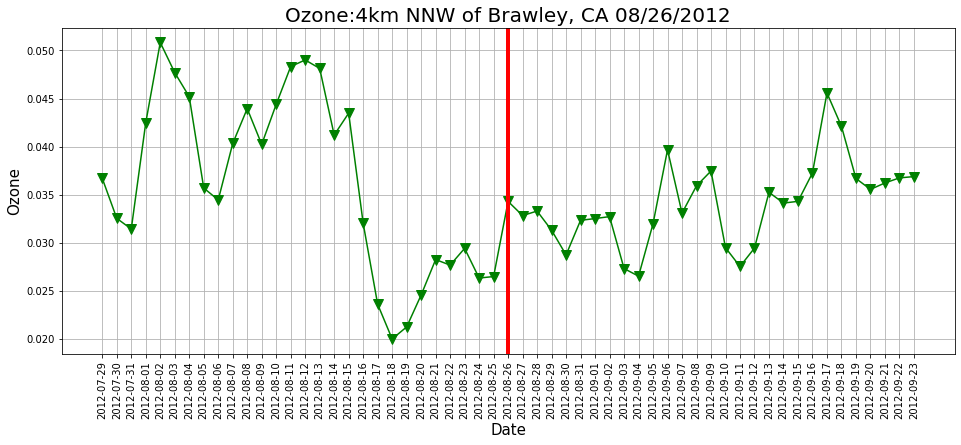

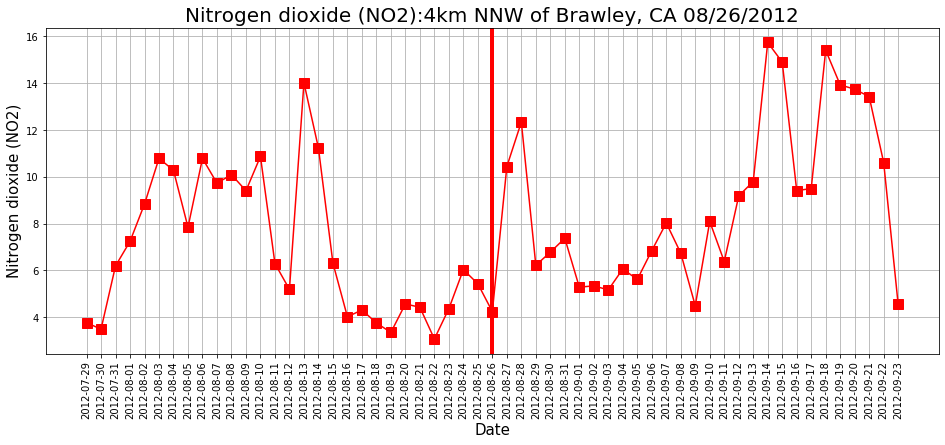

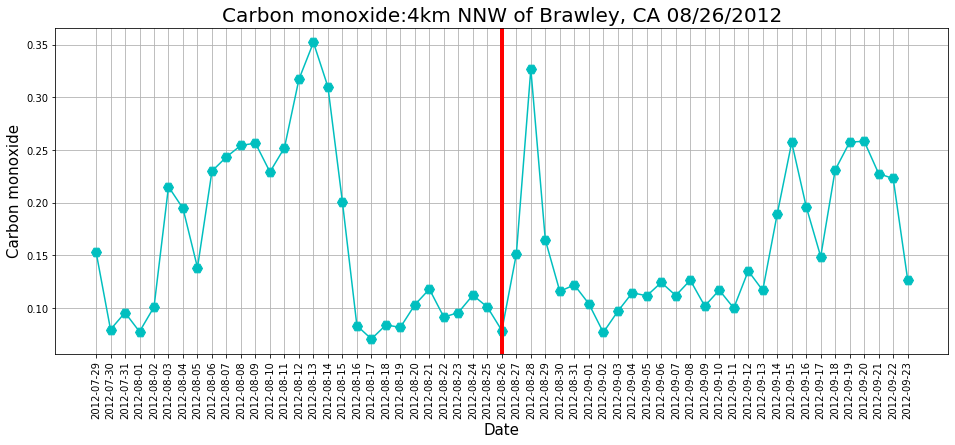

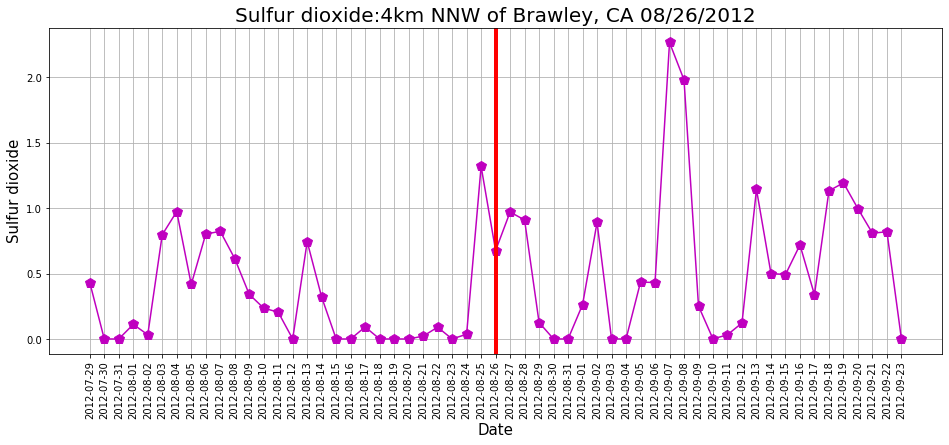

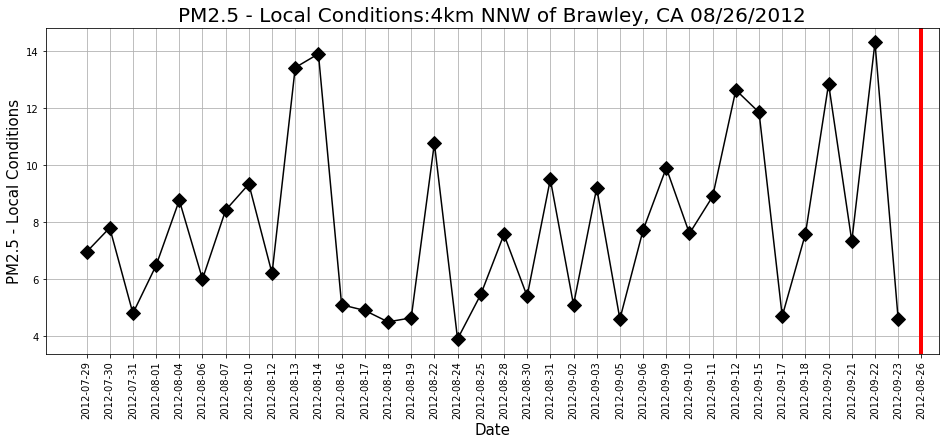

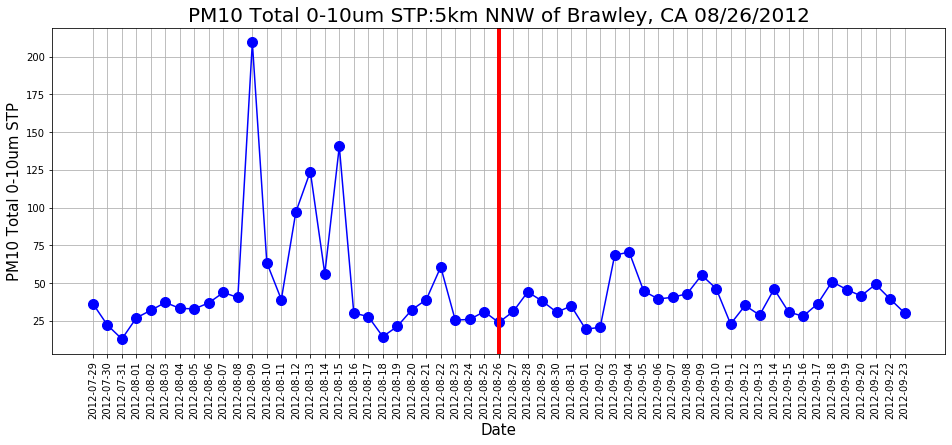

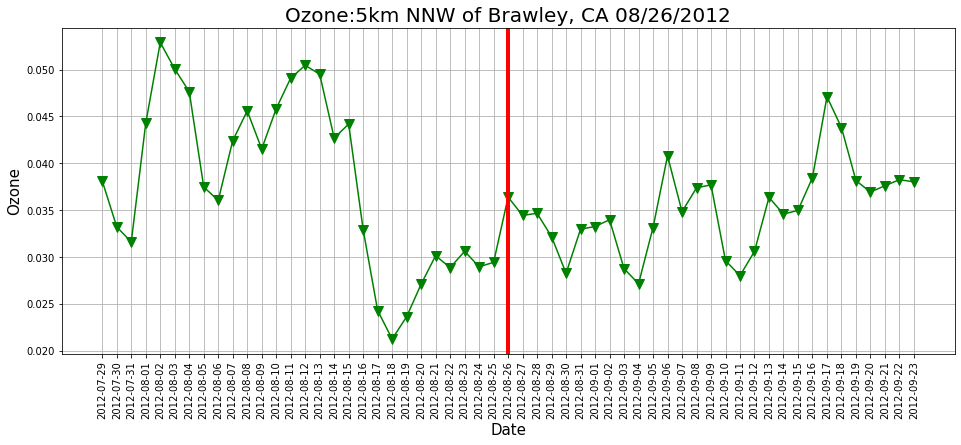

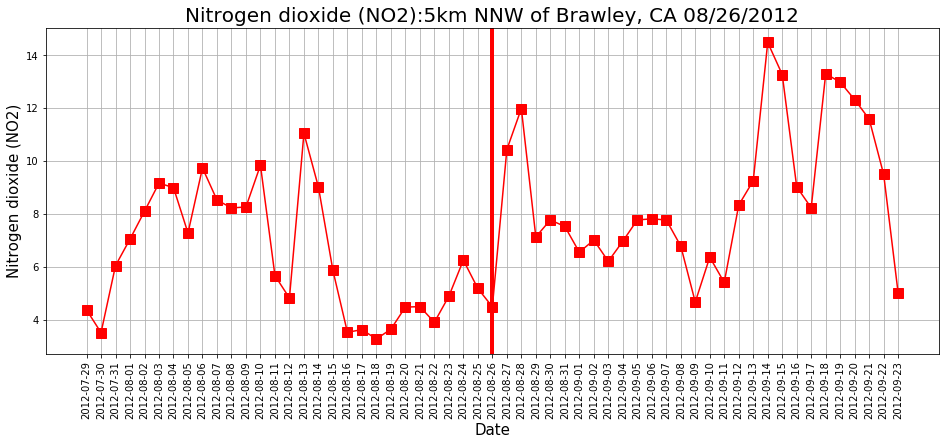

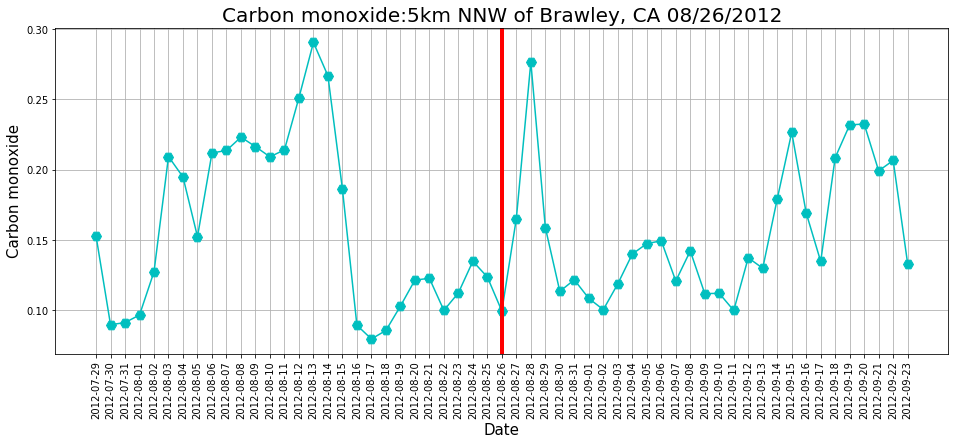

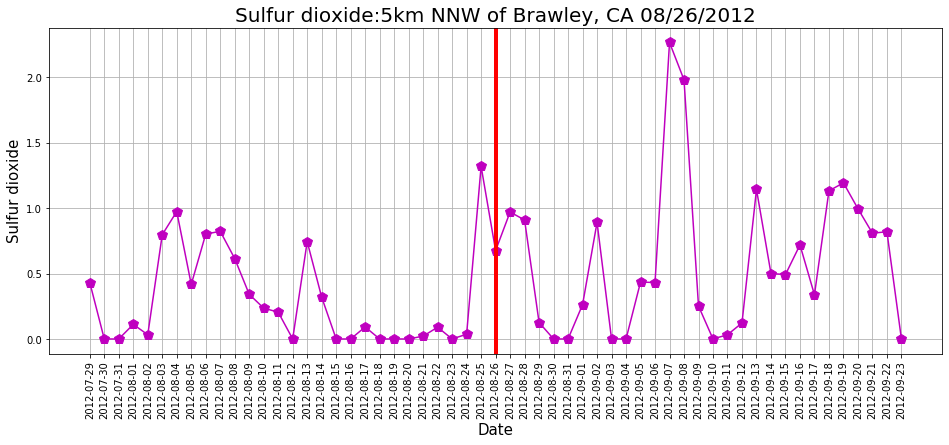

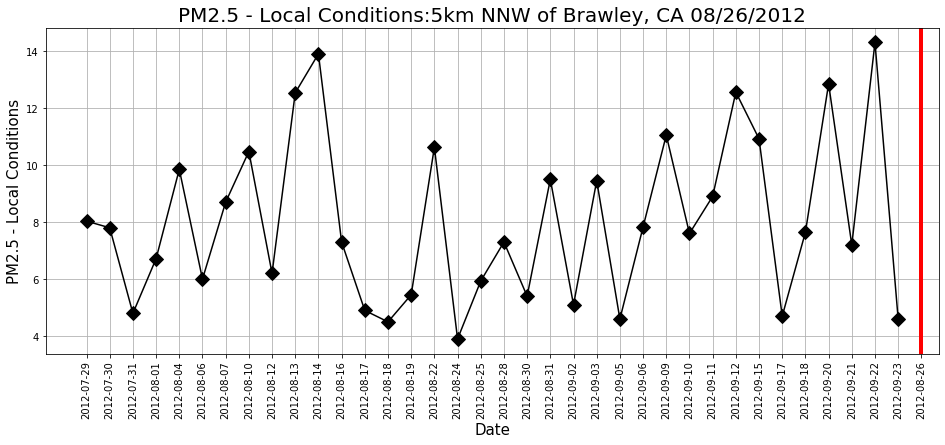

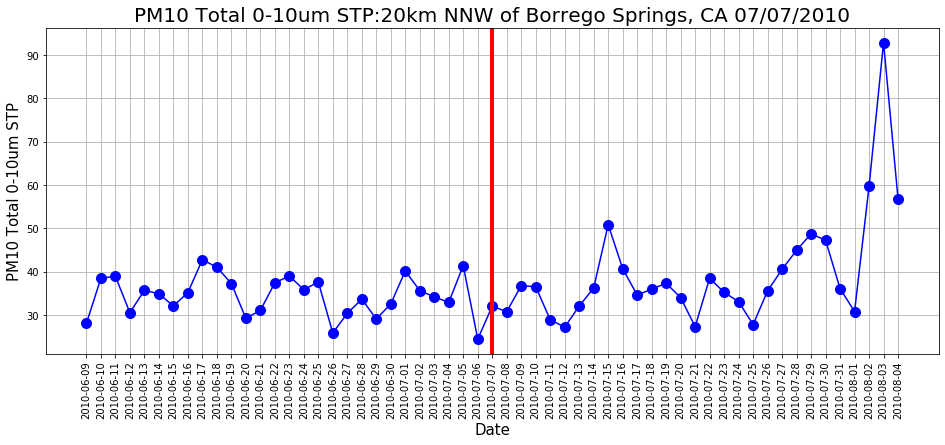

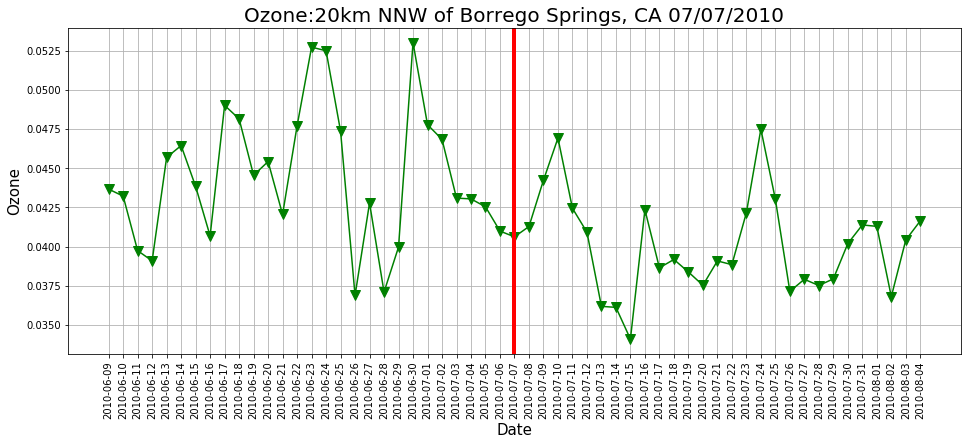

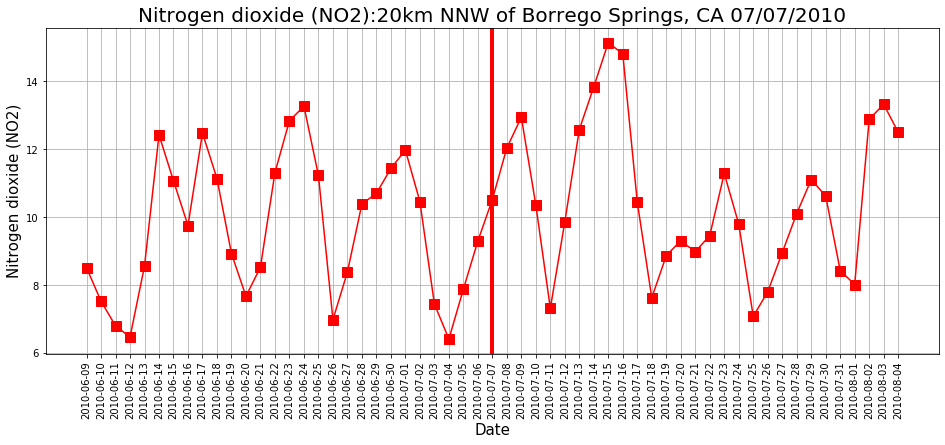

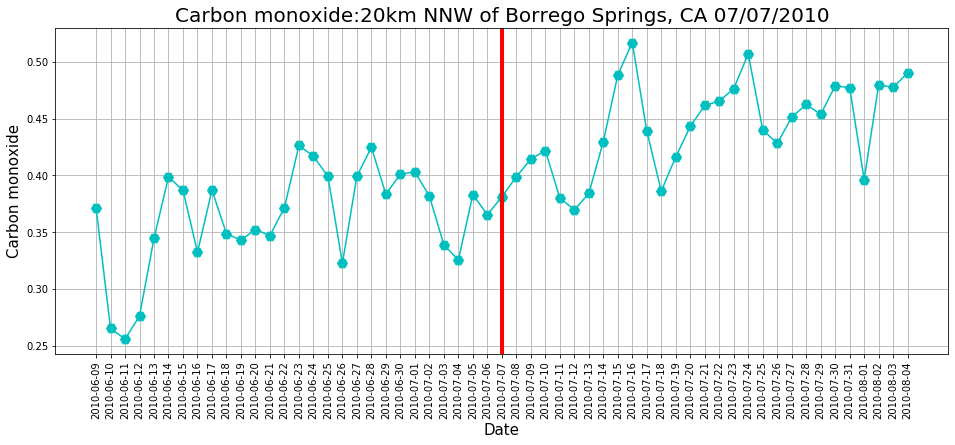

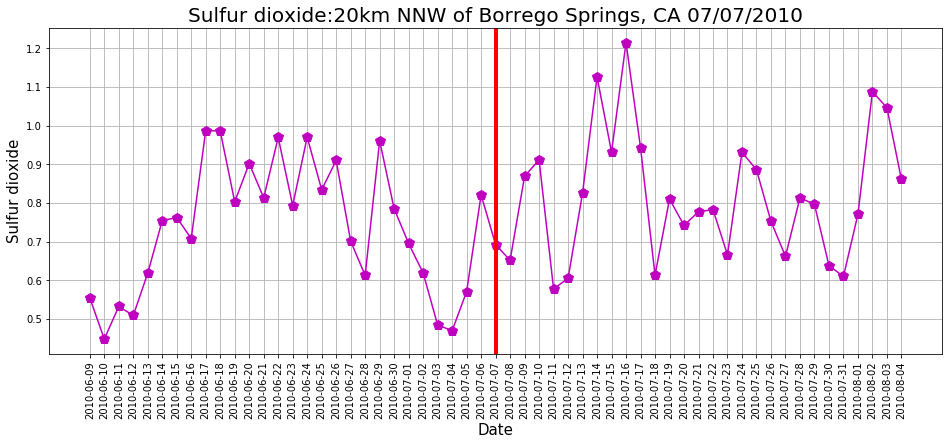

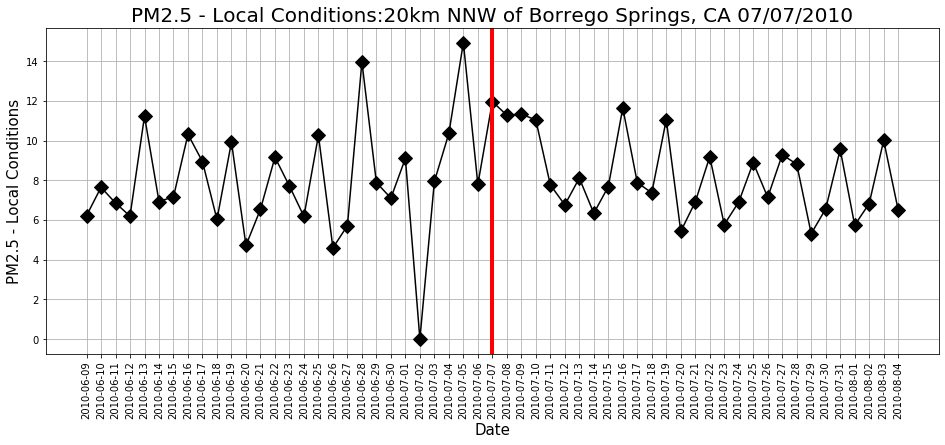

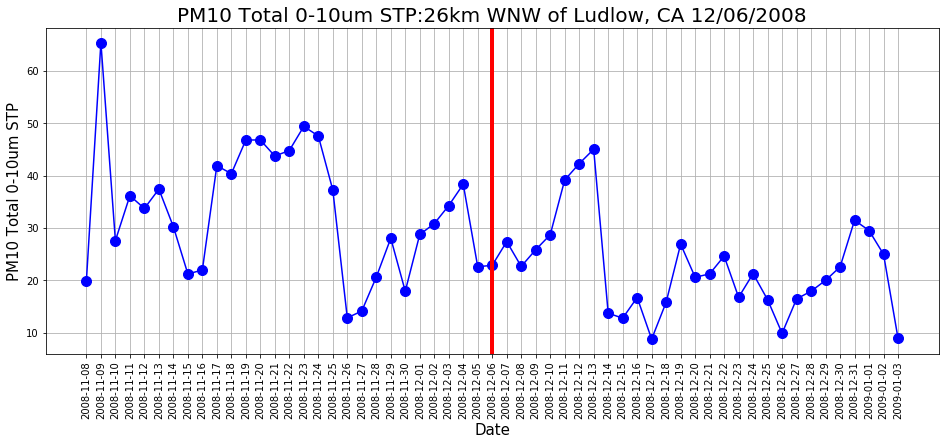

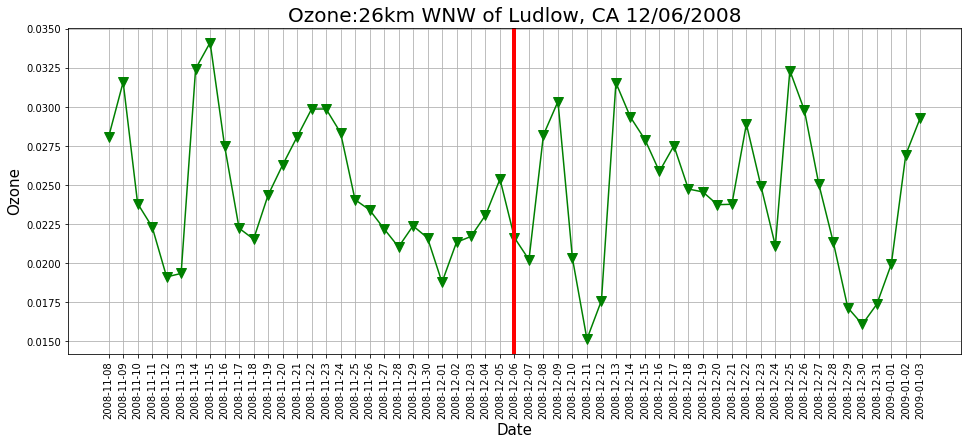

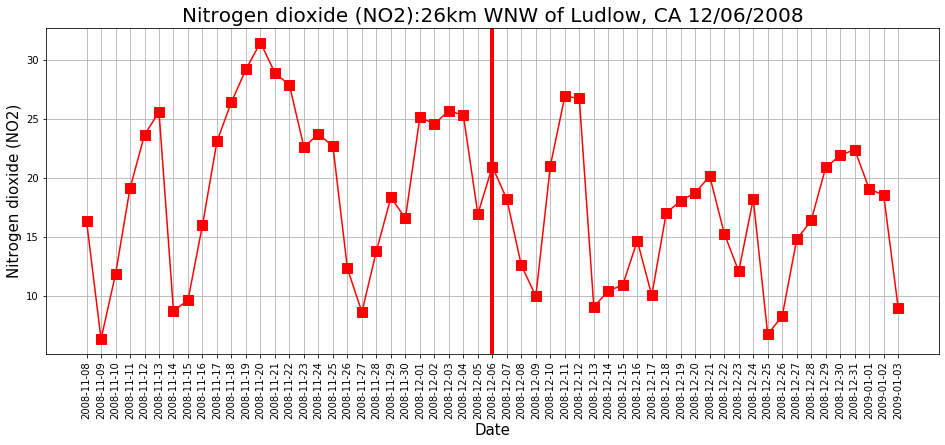

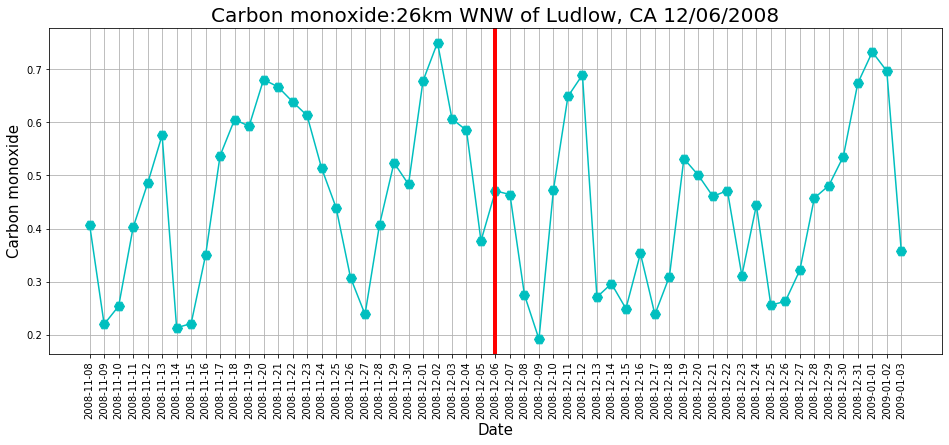

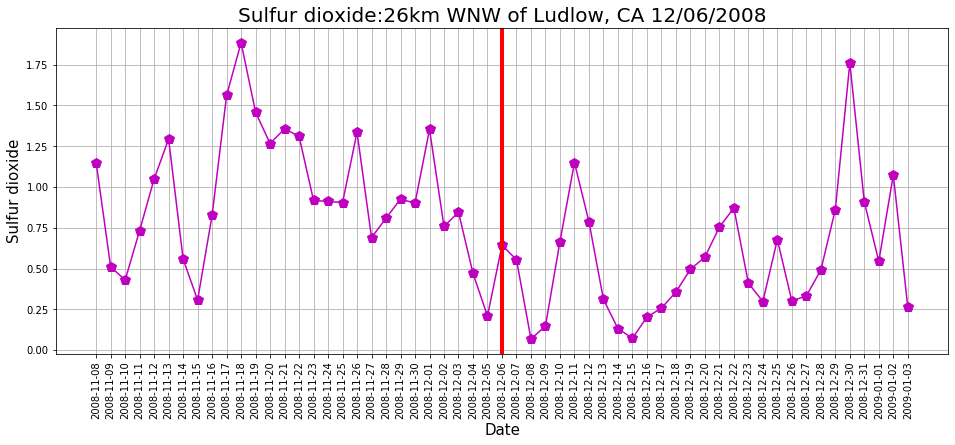

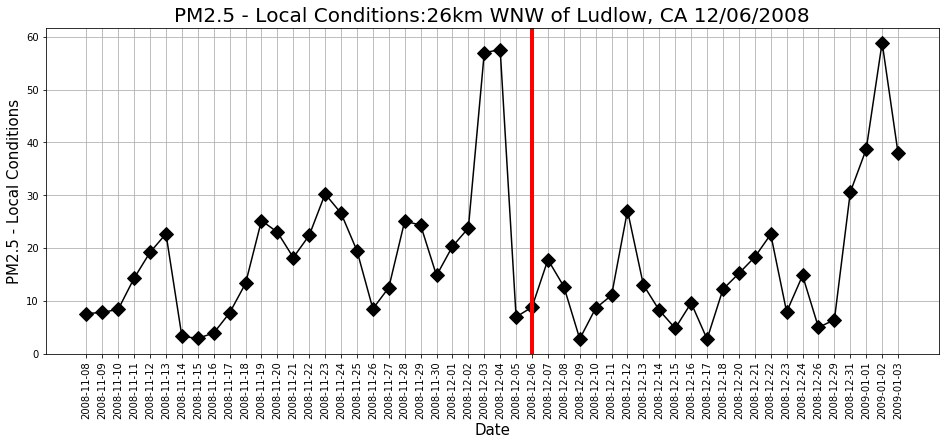

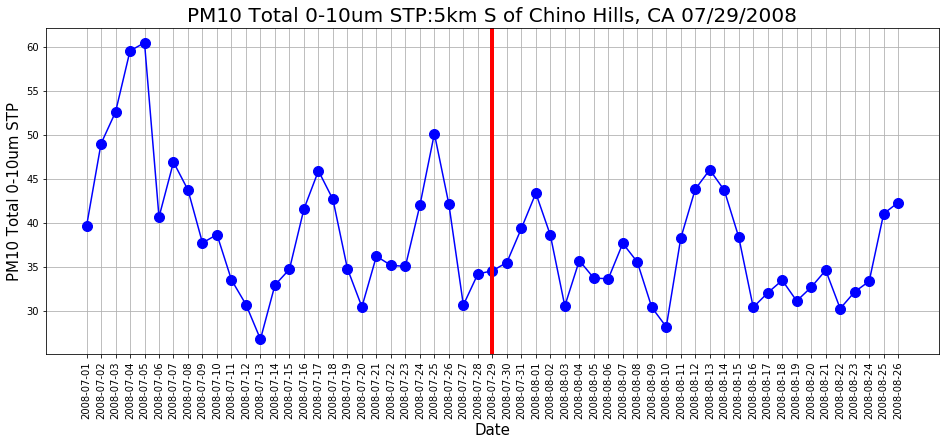

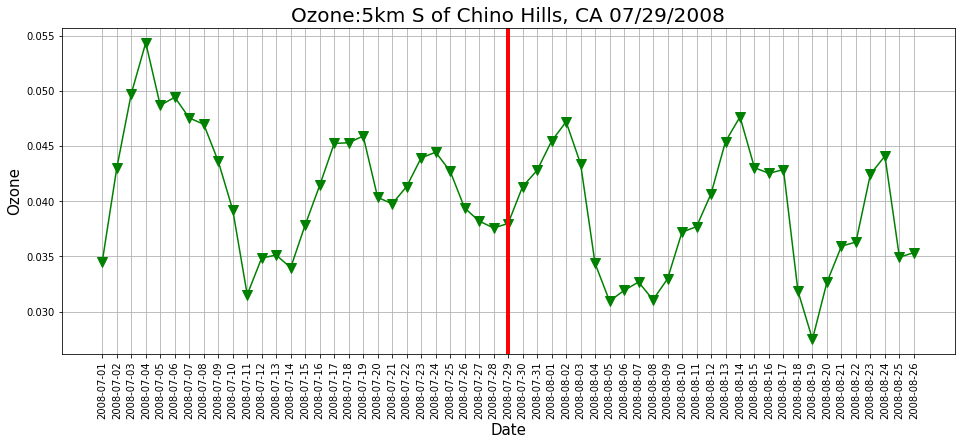

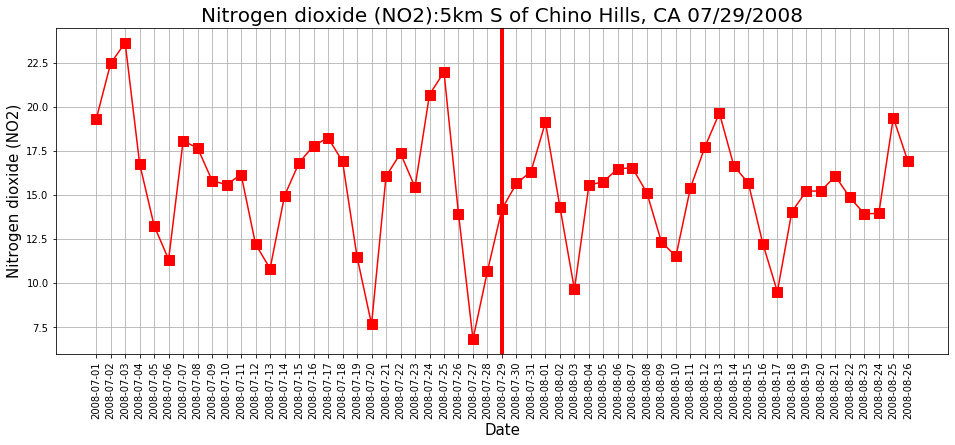

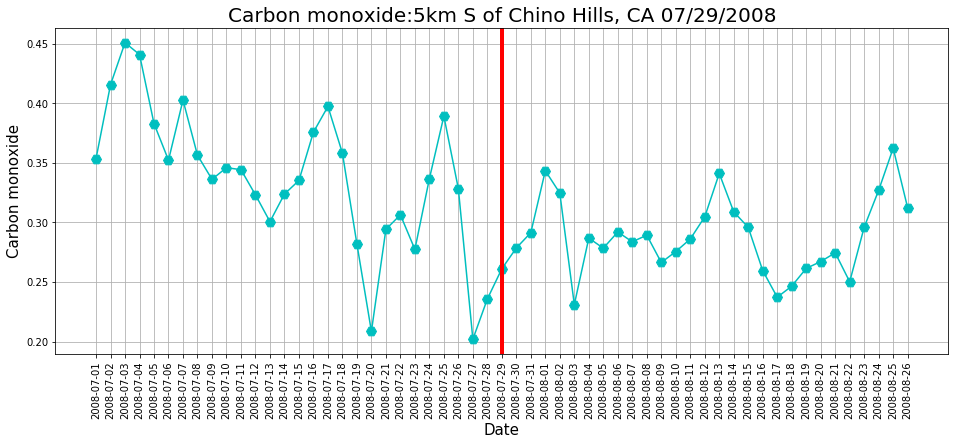

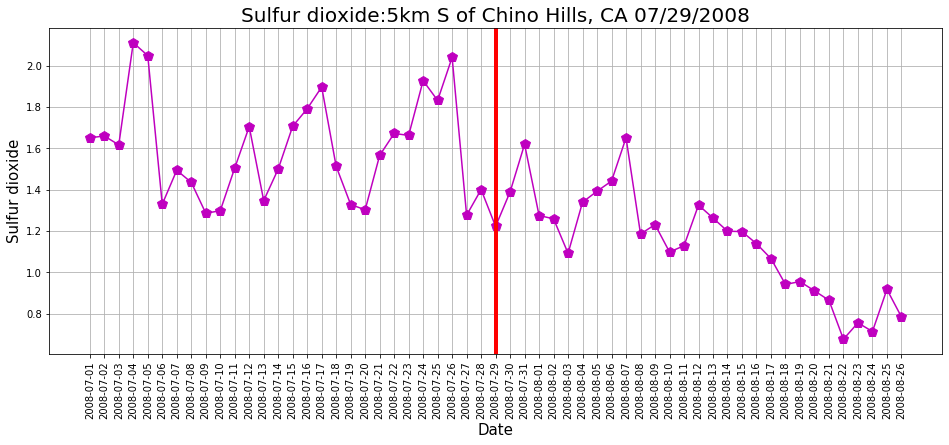

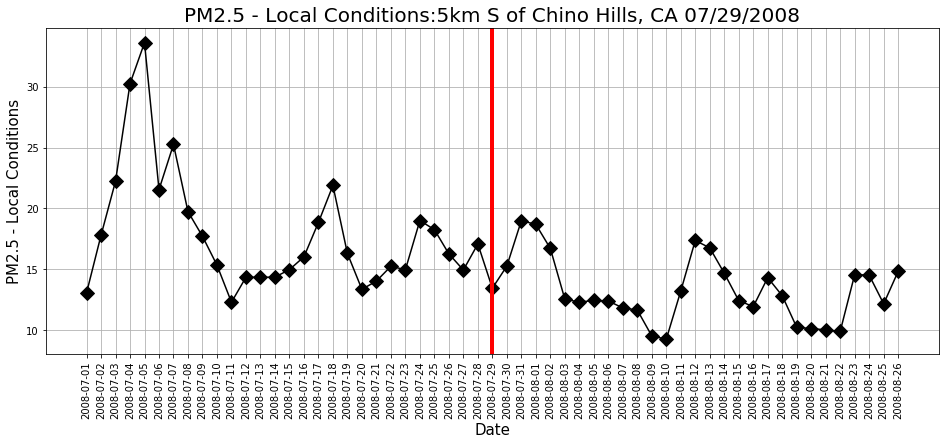

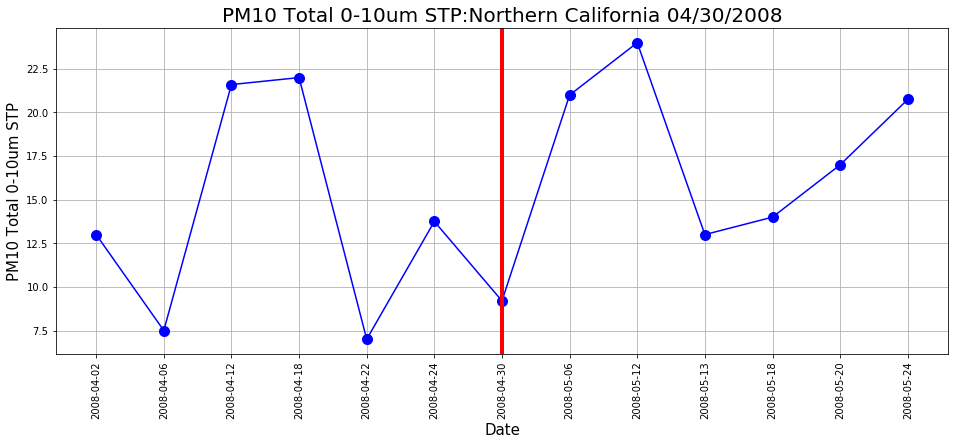

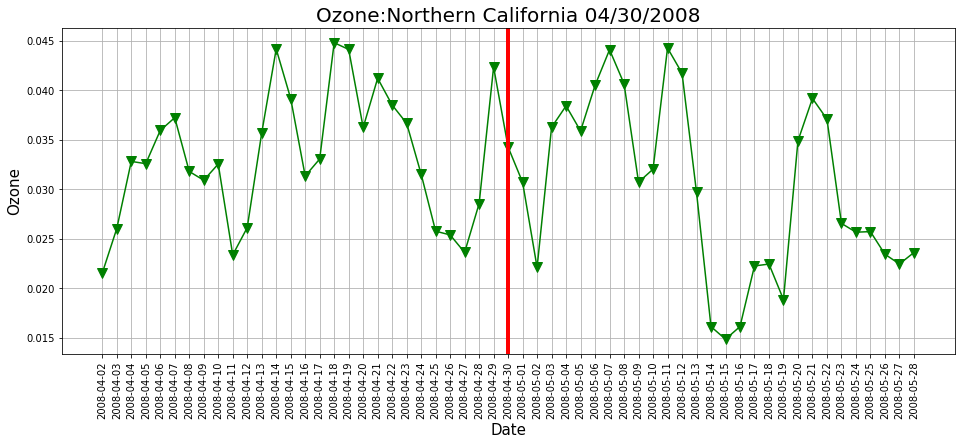

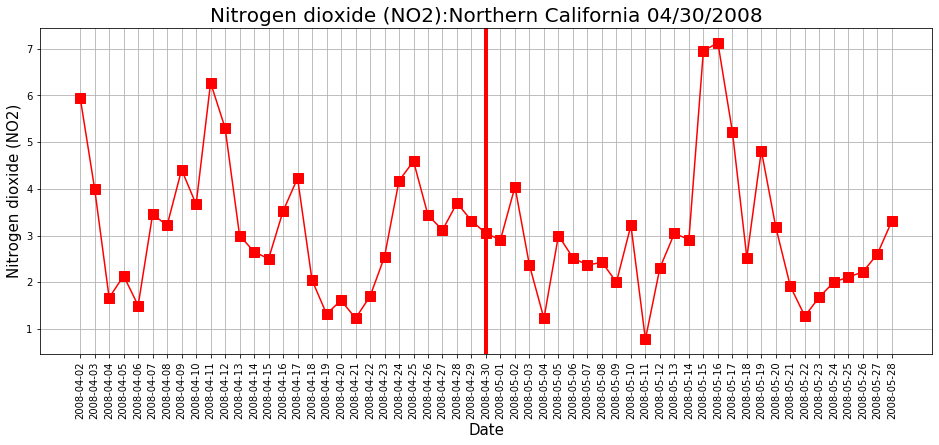

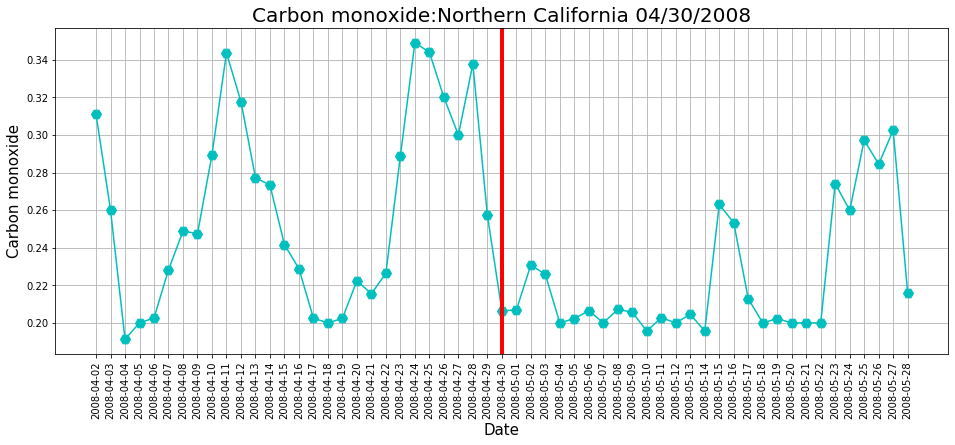

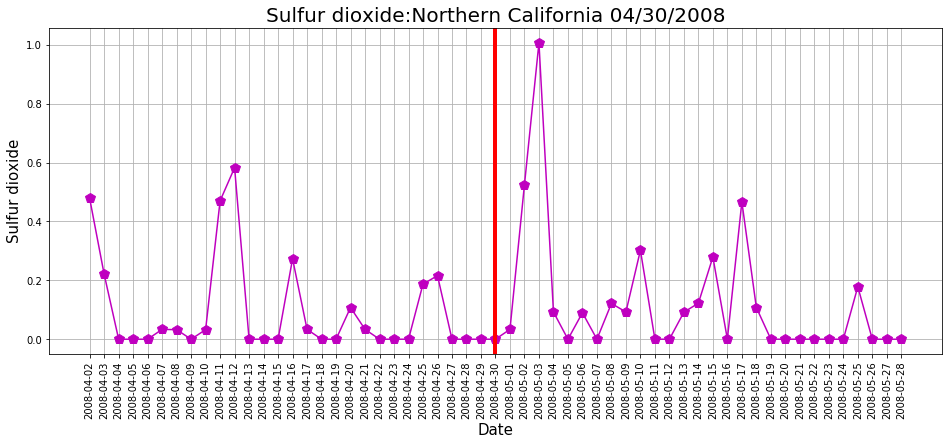

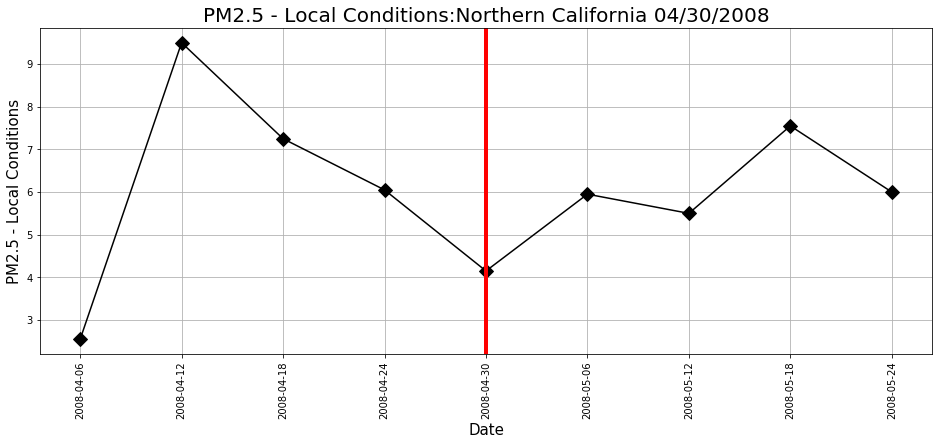

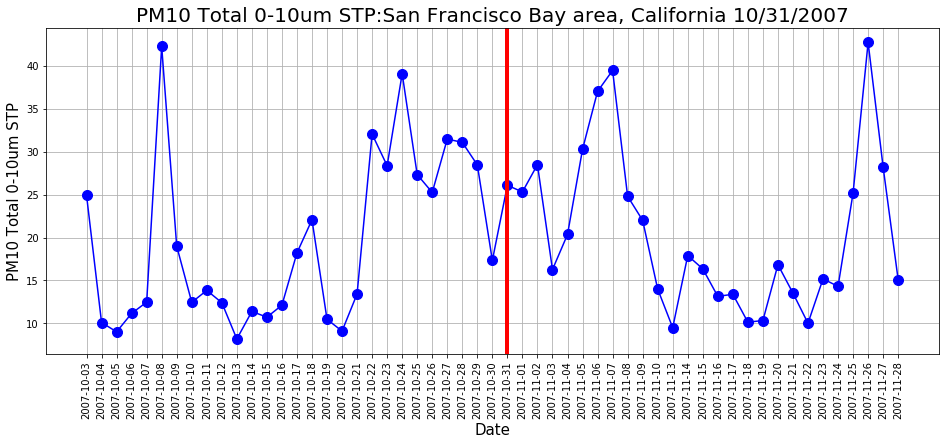

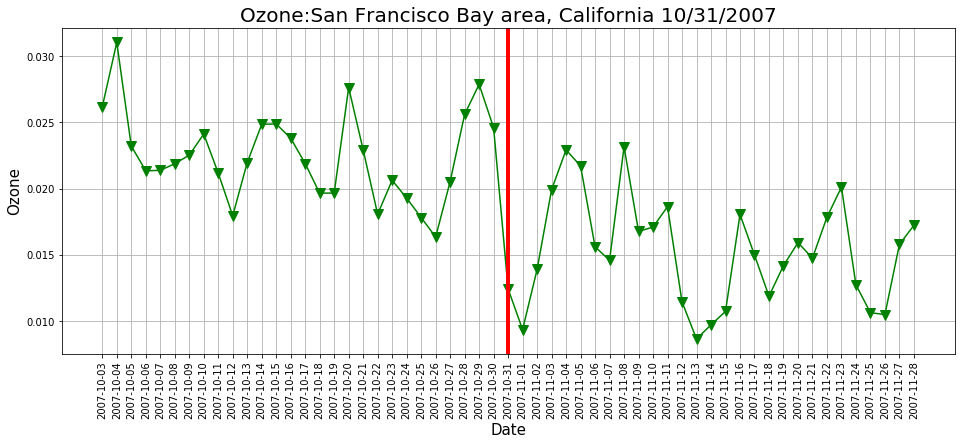

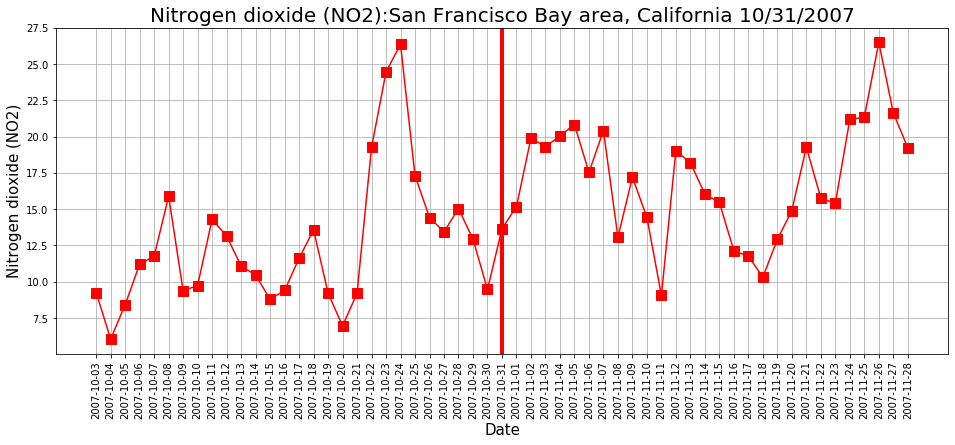

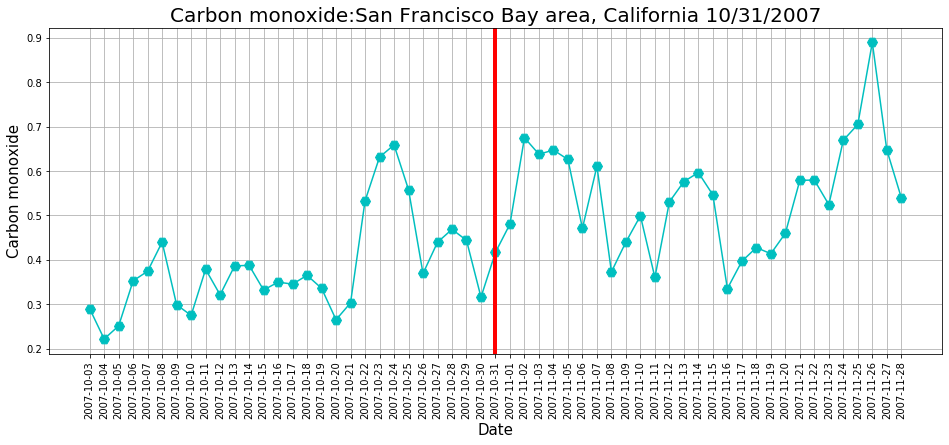

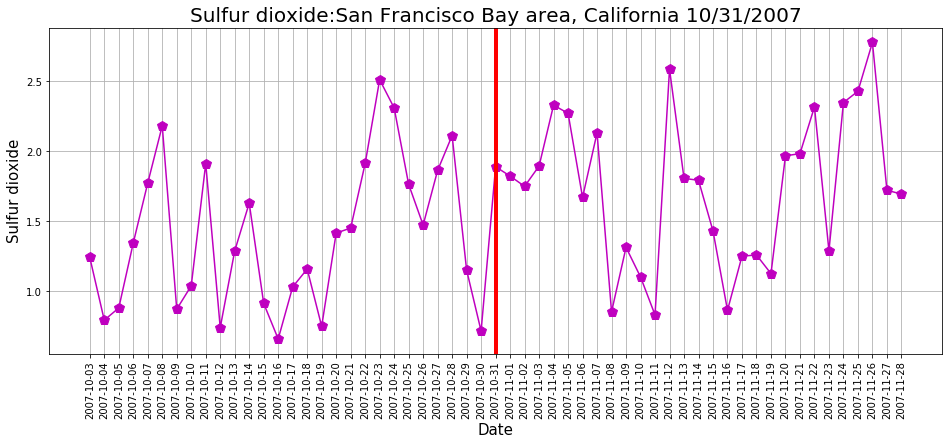

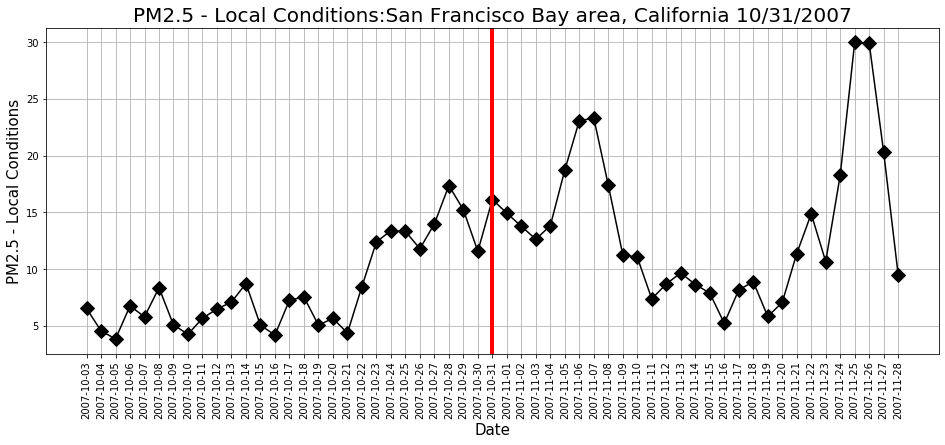

In [17]:
events = earthquakes_df['Identifier'].tolist()
pollutants = record_df['Parameter'].unique().tolist()
colorlines = ['bo', 'gv', 'rs', 'cH', 'mp', 'kD']

earthquake = 0
for event in events:

    i=0

    for pollutant in pollutants:
    
        epochtime = earthquakes_df.iloc[earthquake, 13]
        aqi_event_date = time.strftime('%Y-%m-%d',  time.gmtime(epochtime/1000))
        fancy_event_date = time.strftime('%m/%d/%Y',  time.gmtime(epochtime/1000))
        earthquake_location=earthquakes_df.iloc[earthquake,2]
        earthquake_id = earthquakes_df.iloc[earthquake, 1]
        eventname = (f'{earthquakes_df.iloc[earthquake,2]} {fancy_event_date}')
        titlename = (pollutant + ":" + eventname)
    
        graph_pollutant = record_df[record_df['Parameter']==pollutant]
        graph_pollutant = graph_pollutant[graph_pollutant['Earthquake ID']==events[earthquake]]
        graph_pollutant = graph_pollutant[['Date','Measurement']].sort_values('Date')
        graph_pollutant = graph_pollutant.groupby(['Date']).mean()
        graph_pollutant = graph_pollutant.reset_index()
        

        plt.plot(graph_pollutant['Date'],graph_pollutant['Measurement'],colorlines[i], linestyle='solid', markersize=10)
        plt.title(titlename, fontsize=20)
        plt.xlabel("Date", fontsize = 15)
        #pollutant_unit = 
        plt.ylabel(pollutant, fontsize =15)
        plt.rcParams["figure.figsize"] = [16,6]
        plt.rcParams['xtick.labelsize']=10
        plt.rcParams['ytick.labelsize']=10
        plt.xticks(rotation=90)
        plt.axvline(x=aqi_event_date, color='r', linewidth=4)
        plt.grid()
        plt.savefig('Charts/' + earthquake_id + '-' + pollutant + '.png')
        plt.show()
        
        i+=1
        
    earthquake += 1
    